### Real-Time Surrogate Forecasting of Cardiovascular Dynamics via Control-Aware Koopman Operator Learning
This notebook contains the code to reproduce all result Tables and Figures presented in the manuscript and supplementary materials.

##### Imports & Configuration

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 3

# Core
from pathlib import Path
import pickle
import math
from itertools import combinations
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

import seaborn as sns
import plotly.express as px
from IPython.display import display

# Statistical tests & ML
from scipy.stats import shapiro, f_oneway, ttest_ind, kruskal, mannwhitneyu

# Notebook utilities
import notebook_utils as nu

# Paths & constants
results_base_path = Path("../results")
data_base_path    = Path("../data")
inference_time_full_model_s = 2.05  # sec

# Y‑axis labels for signals
ylab = ['$P_{ra}$', '$V_{ra}$', '$P_{rv}$', '$V_{rv}$','$P_{vp}$', '$P_{la}$', '$V_{la}$', 
        '$P_{lv}$', '$V_{lv}$', '$Q_{i,lv}$', '$Q_{o,lv}$', '$P_{ao}$']

units = ['mmHg', 'mL', 'mmHg', 'mL', 'mmHg', 'mmHg', 'mL', 'mmHg', 'mL', 'mL/s', 'mL/s', 'mmHg']

# Plotting defaults
sns.set_theme('paper')
sns.set_style('white')
sns.set_palette('colorblind')
sns.set_context('notebook', font_scale=1.1)

##### Figure 2

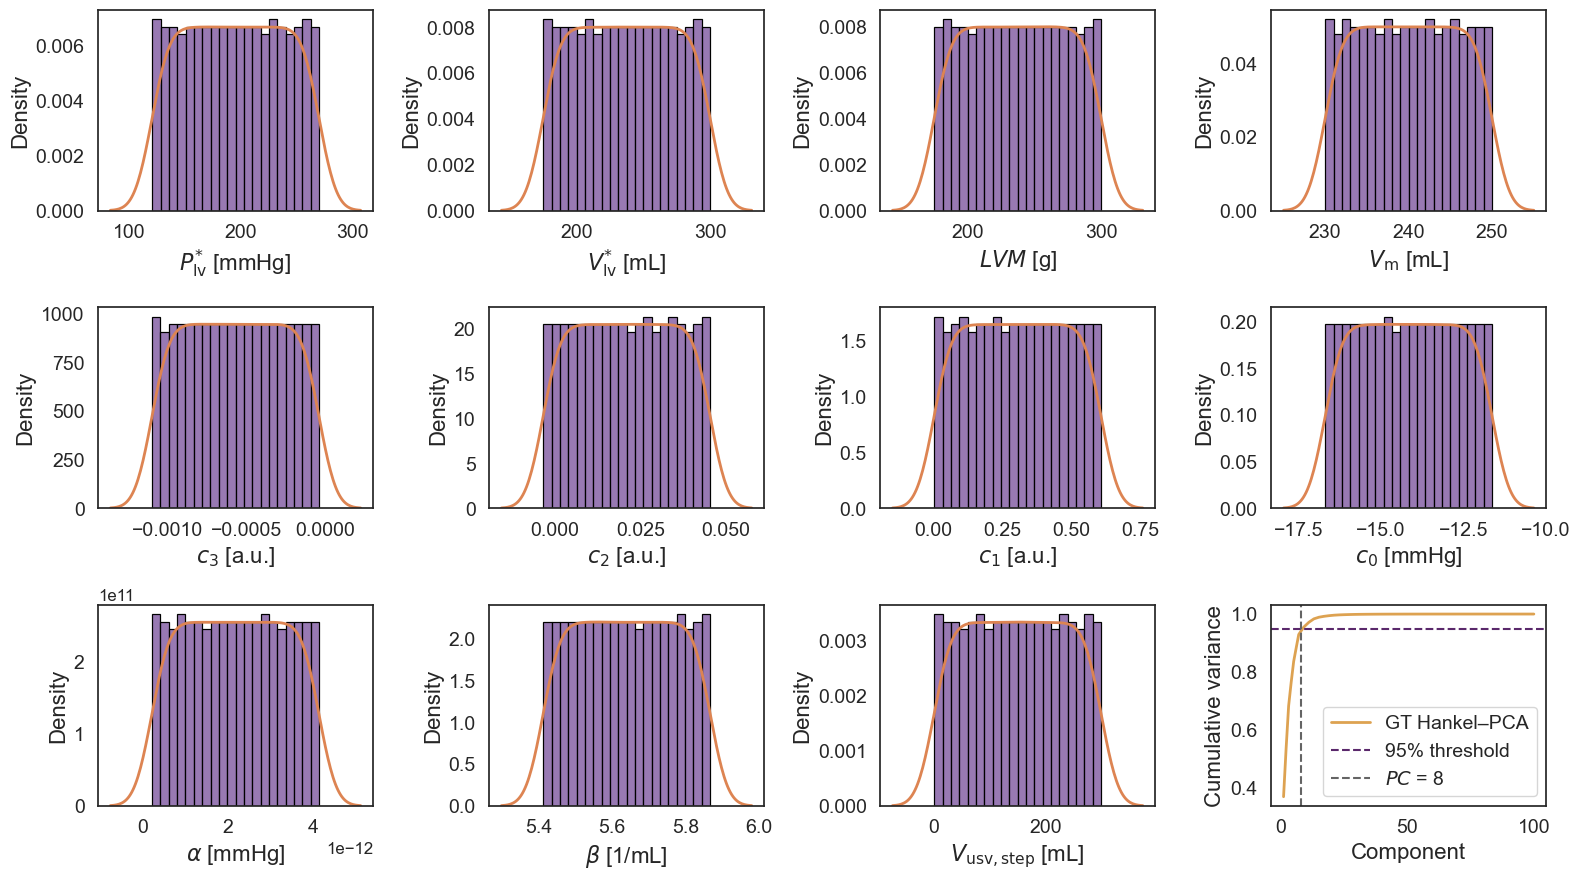

In [2]:
# load the cardiovascular parameter space data
df = pd.read_csv(data_base_path / "cardiovascular_parameter_space.csv")  

# Set seaborn theme and consistent color palette
fig1_palette = sns.color_palette("deep")
hist_color = fig1_palette[0]       # blue
kde_color = fig1_palette[1]        # orange
hankel_color = fig1_palette[2]     # green
threshold_color = fig1_palette[3]  # red

# Move 'Vusv_step' to the end of column order
columns = [col for col in df.columns if col != "Vusv_step"] + ["Vusv_step"]

# Determine layout
num_cols = len(columns)
cols_per_row = 4
num_rows = math.ceil((num_cols + 1) / cols_per_row)  # +1 for Hankel–PCA
total_plots = num_rows * cols_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 4, num_rows * 3))
axes = axes.flatten()

# Plot each column histogram
for i, column in enumerate(columns):
    sns.histplot(df[column], bins=20, stat='density', ax=axes[i], color='#764c9a', edgecolor="black")
    sns.kdeplot(df[column], ax=axes[i], color=kde_color, lw=2)
    label = nu.LABEL_MAP.get(column, column)
    axes[i].set_xlabel(label, fontsize=16)
    axes[i].set_ylabel("Density", fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)
    axes[i].grid(False)

# ── Load GT for Hankel–PCA analysis ────────────────────────────────
results = nu.load_postprocessing_results(results_base_path / "koopman" / "koopman_postprocessing_results.pkl")
gt_all = results["true_per_trajectory"]

# ── Plot Hankel–PCA into final slot ─────────────────────────────────
cumvar, p_pca = nu.average_pca_hankel_curves(gt_all, window=100, var_explained=0.95)

ax = axes[len(columns)]  # next subplot after histograms
ax.plot(np.arange(1, len(cumvar)+1), cumvar, label="GT Hankel–PCA", color='#dda251', lw=2)
ax.axhline(0.95, color='#5a286b', linestyle="--", label="95% threshold", lw=1.5)
ax.axvline(p_pca, color='#646464', linestyle="--", label=f"$PC$ = {p_pca}", lw=1.5)
ax.set_xlabel("Component", fontsize=16)
ax.set_ylabel("Cumulative variance", fontsize=16)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(False)

plt.tight_layout()
fig.savefig(results_base_path / "figures" / "figure2.svg", format="svg", bbox_inches="tight")
plt.show()


##### Figure 3a-c

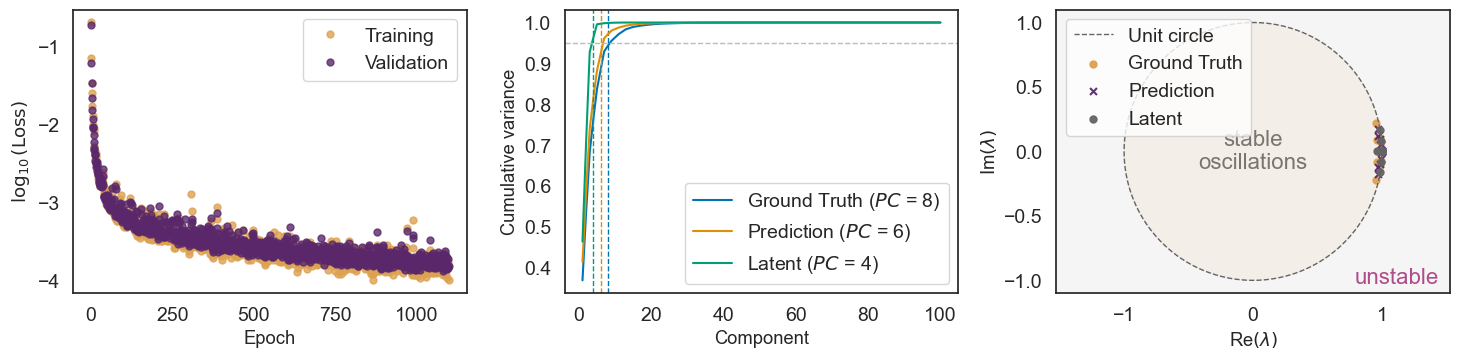

In [3]:
# locate files, load checkpoint and params
errors = nu.get_latest_errors(str(results_base_path / "koopman" / "*_error.csv"))
params, W, b, model = nu.load_latest_ckpt(str(results_base_path / "koopman" / "*_model.ckpt"))
results = nu.load_postprocessing_results(results_base_path / "koopman" / "koopman_postprocessing_results.pkl")

# Load test data and normalize U
n_traj, Xk = nu.load_test_data(data_base_path / params['data_name'], params)
# Apply encoder to get latent trajectories
yk = nu.encoder_apply(Xk, W, b, 'E', sum(k.startswith('WE') for k in W))
yk_all = nu.reshape_latent_trajs(yk, n_traj, params)

# Reshape latent trajectories
data_sources = {
    "Ground Truth": results["true_per_trajectory"],
    "Prediction": results["pred_per_trajectory"],
    "Latent": yk_all
}

nu.plot_errors_hankel_dmd(errors, data_sources, params, results_base_path, fig_name="figure3a-c")

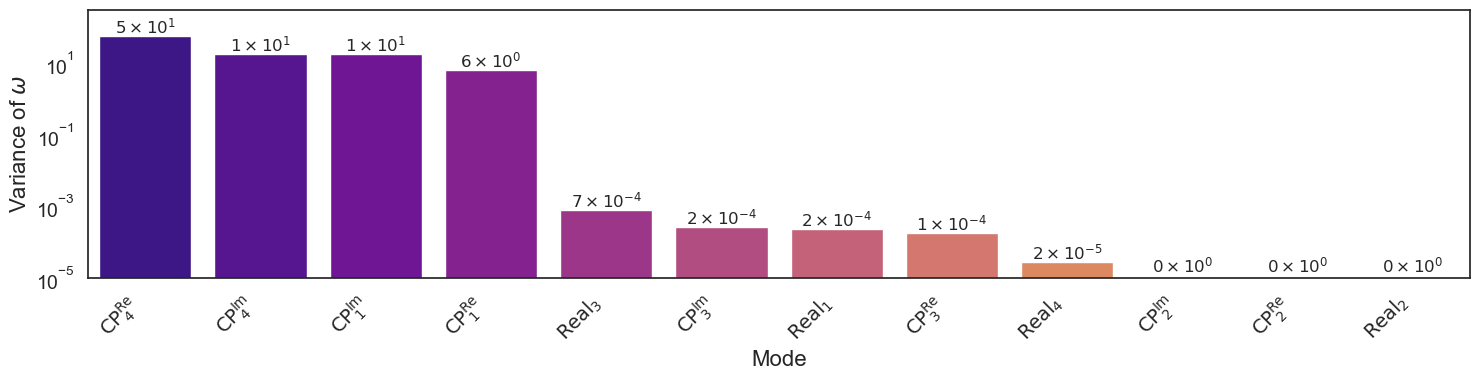

In [4]:
# Omega Variance Barplot
omegas = nu.omega_net_apply(yk, W, b, params['num_real'], params['num_complex_pairs'],
                         sum(k.startswith(('WOC', 'WOR')) for k in W),
                         act_type=params.get('act_type', 'relu'))

# Stack & label
complex_labels = [f'CP{i+1}_{t}' for i in range(params['num_complex_pairs']) for t in ('Re', 'Im')]
real_labels = [f'Real{i+1}' for i in range(params['num_real'])]
df = pd.concat([
    pd.DataFrame(np.hstack(omegas[:params['num_complex_pairs']]), columns=complex_labels) if params['num_complex_pairs'] else pd.DataFrame(),
    pd.DataFrame(np.hstack(omegas[params['num_complex_pairs']:]), columns=real_labels) if params['num_real'] else pd.DataFrame()
], axis=1).melt(var_name='Mode', value_name='omega')

# Variance
var_df = df.groupby('Mode')['omega'].var().reset_index(name='var')
var_df['Label'] = var_df['Mode'].apply(nu.latex_mode_label)
var_df = var_df.sort_values('var', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(15, 4))
sns.barplot(data=var_df, x='Label', y='var', hue='Label', palette='plasma', legend=False)
plt.yscale('log'); plt.ylim(1e-5, 3e2)
plt.xlabel('Mode', fontsize=16); plt.ylabel(r'Variance of $\omega$', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14); plt.yticks(fontsize=14)
for i, v in enumerate(var_df['var']):
    e = f"{v:.1e}".split('e')
    plt.text(i, max(v*1.2, 1.5e-5), rf"${int(float(e[0]))} \times 10^{{{int(e[1])}}}$", ha='center', fontsize=12)
plt.tight_layout()
plt.savefig(results_base_path / "figures/figure3d.svg", format='svg')
plt.show()

##### Figure 4a

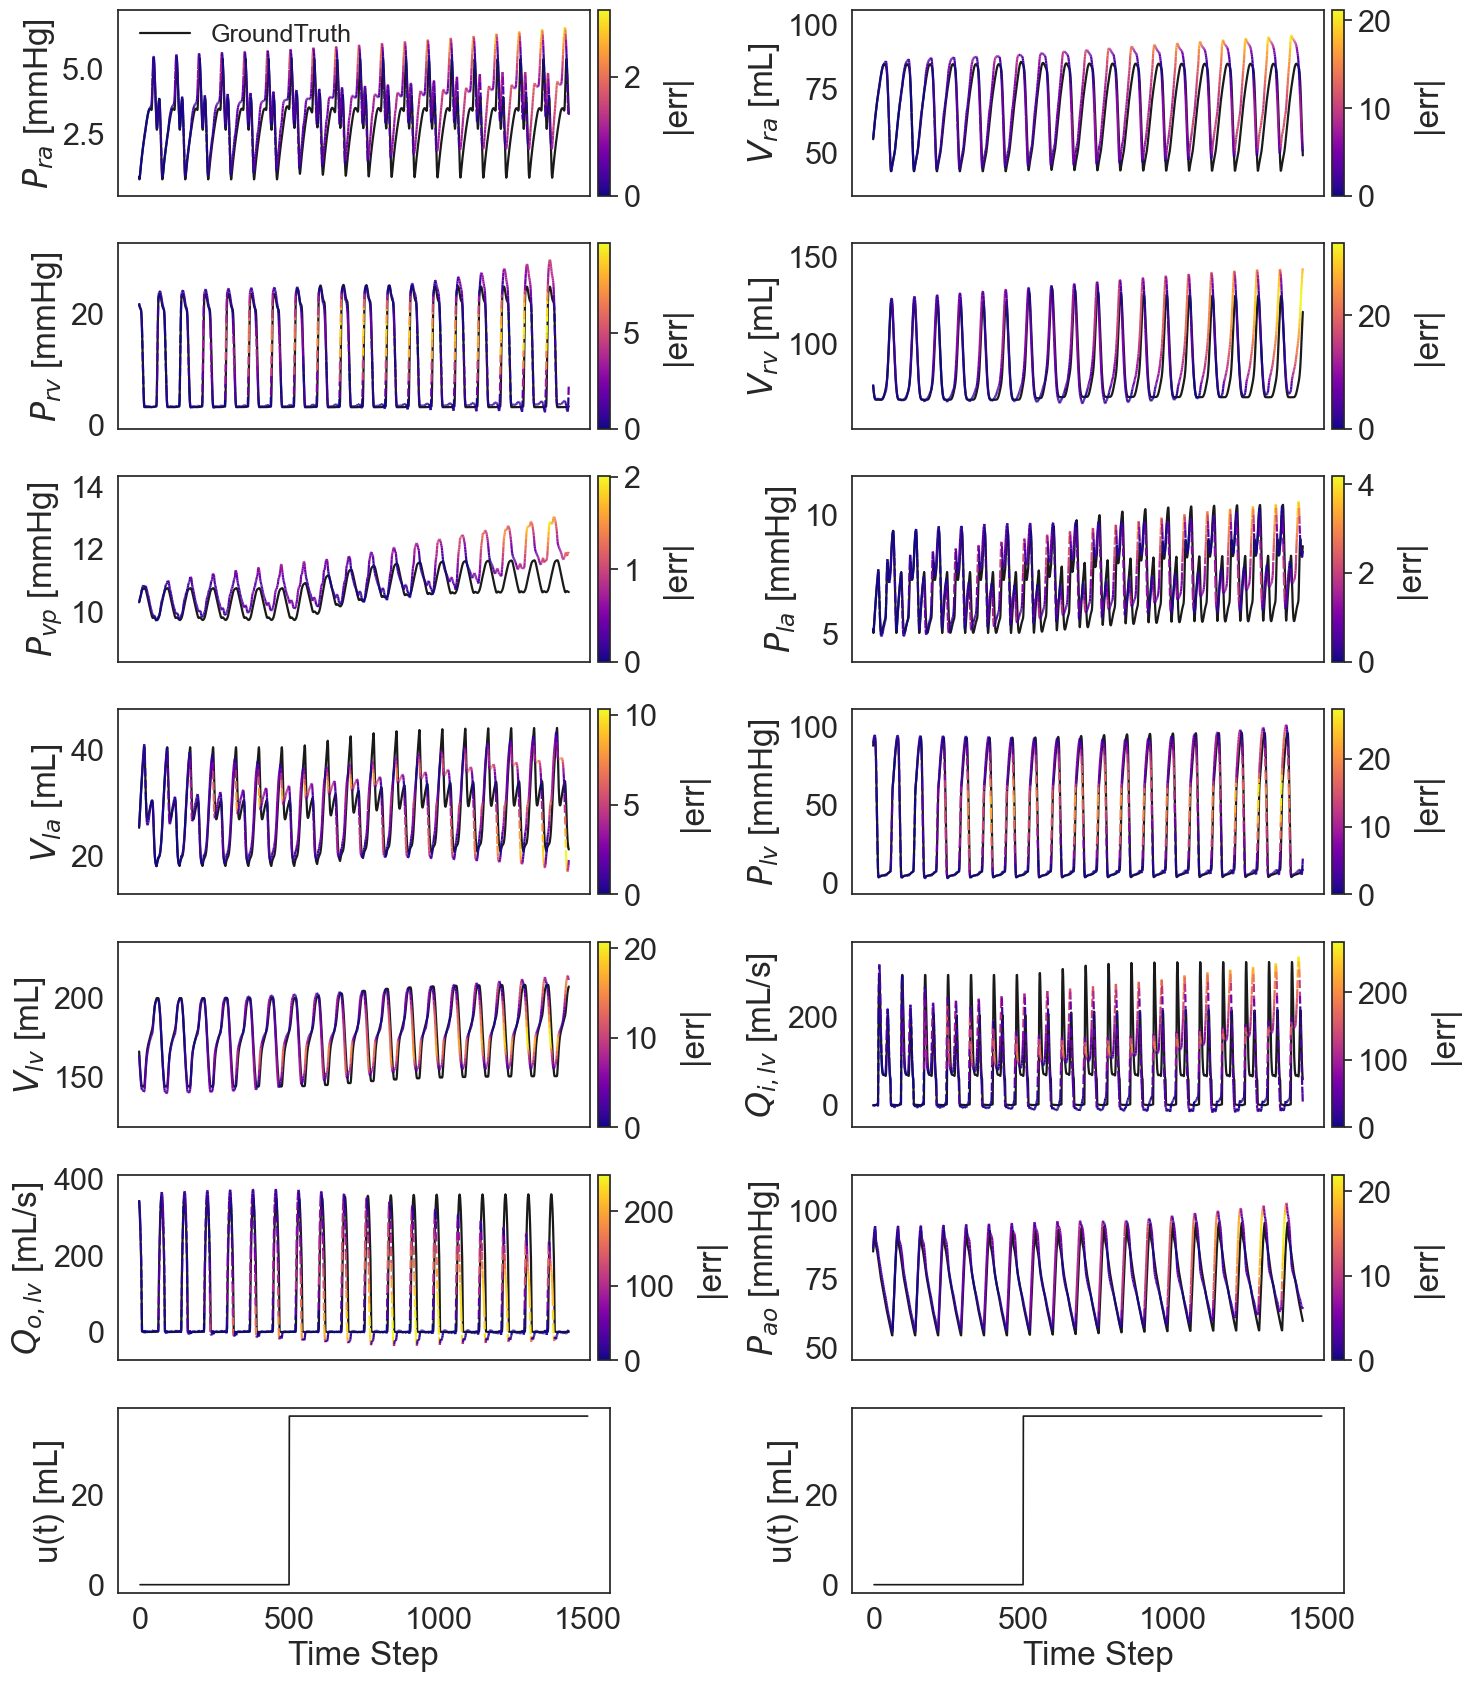

In [5]:
true_tr = results['true_per_trajectory']
pred_tr = results['pred_per_trajectory']
ctrl_tr = results['u_per_trajectory'].reshape(*true_tr.shape[:2])
rmse_tr = results['rmse_per_trajectory']

best_idx = int(np.argmin(rmse_tr))
y_true_all, y_pred_all = true_tr[best_idx], pred_tr[best_idx]
u_seq = ctrl_tr[best_idx]

cmap_err = sns.color_palette("plasma", as_cmap=True)

# ─── Plot Layout ────────────────────────────────────────────────────────
n_rows = len(ylab) + 1
fig_h = 1.35 * n_rows
fig, axes = plt.subplots(7, 2, figsize=(15, fig_h), sharex=True)
axes = axes.flatten()

for i, sig in enumerate(ylab):
    label = f"{sig} [{units[i]}]"
    nu.plot_signal_panel(axes[i], y_true_all[:, i], y_pred_all[:, i], cmap_err,
                       ylabel=label, show_legend=(i == 0))

nu.plot_control_panel(axes[-1], u_seq)
nu.plot_control_panel(axes[-2], u_seq)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(results_base_path / "figures" / "figure4a.svg", format='svg')
plt.show()

##### Figure 4b

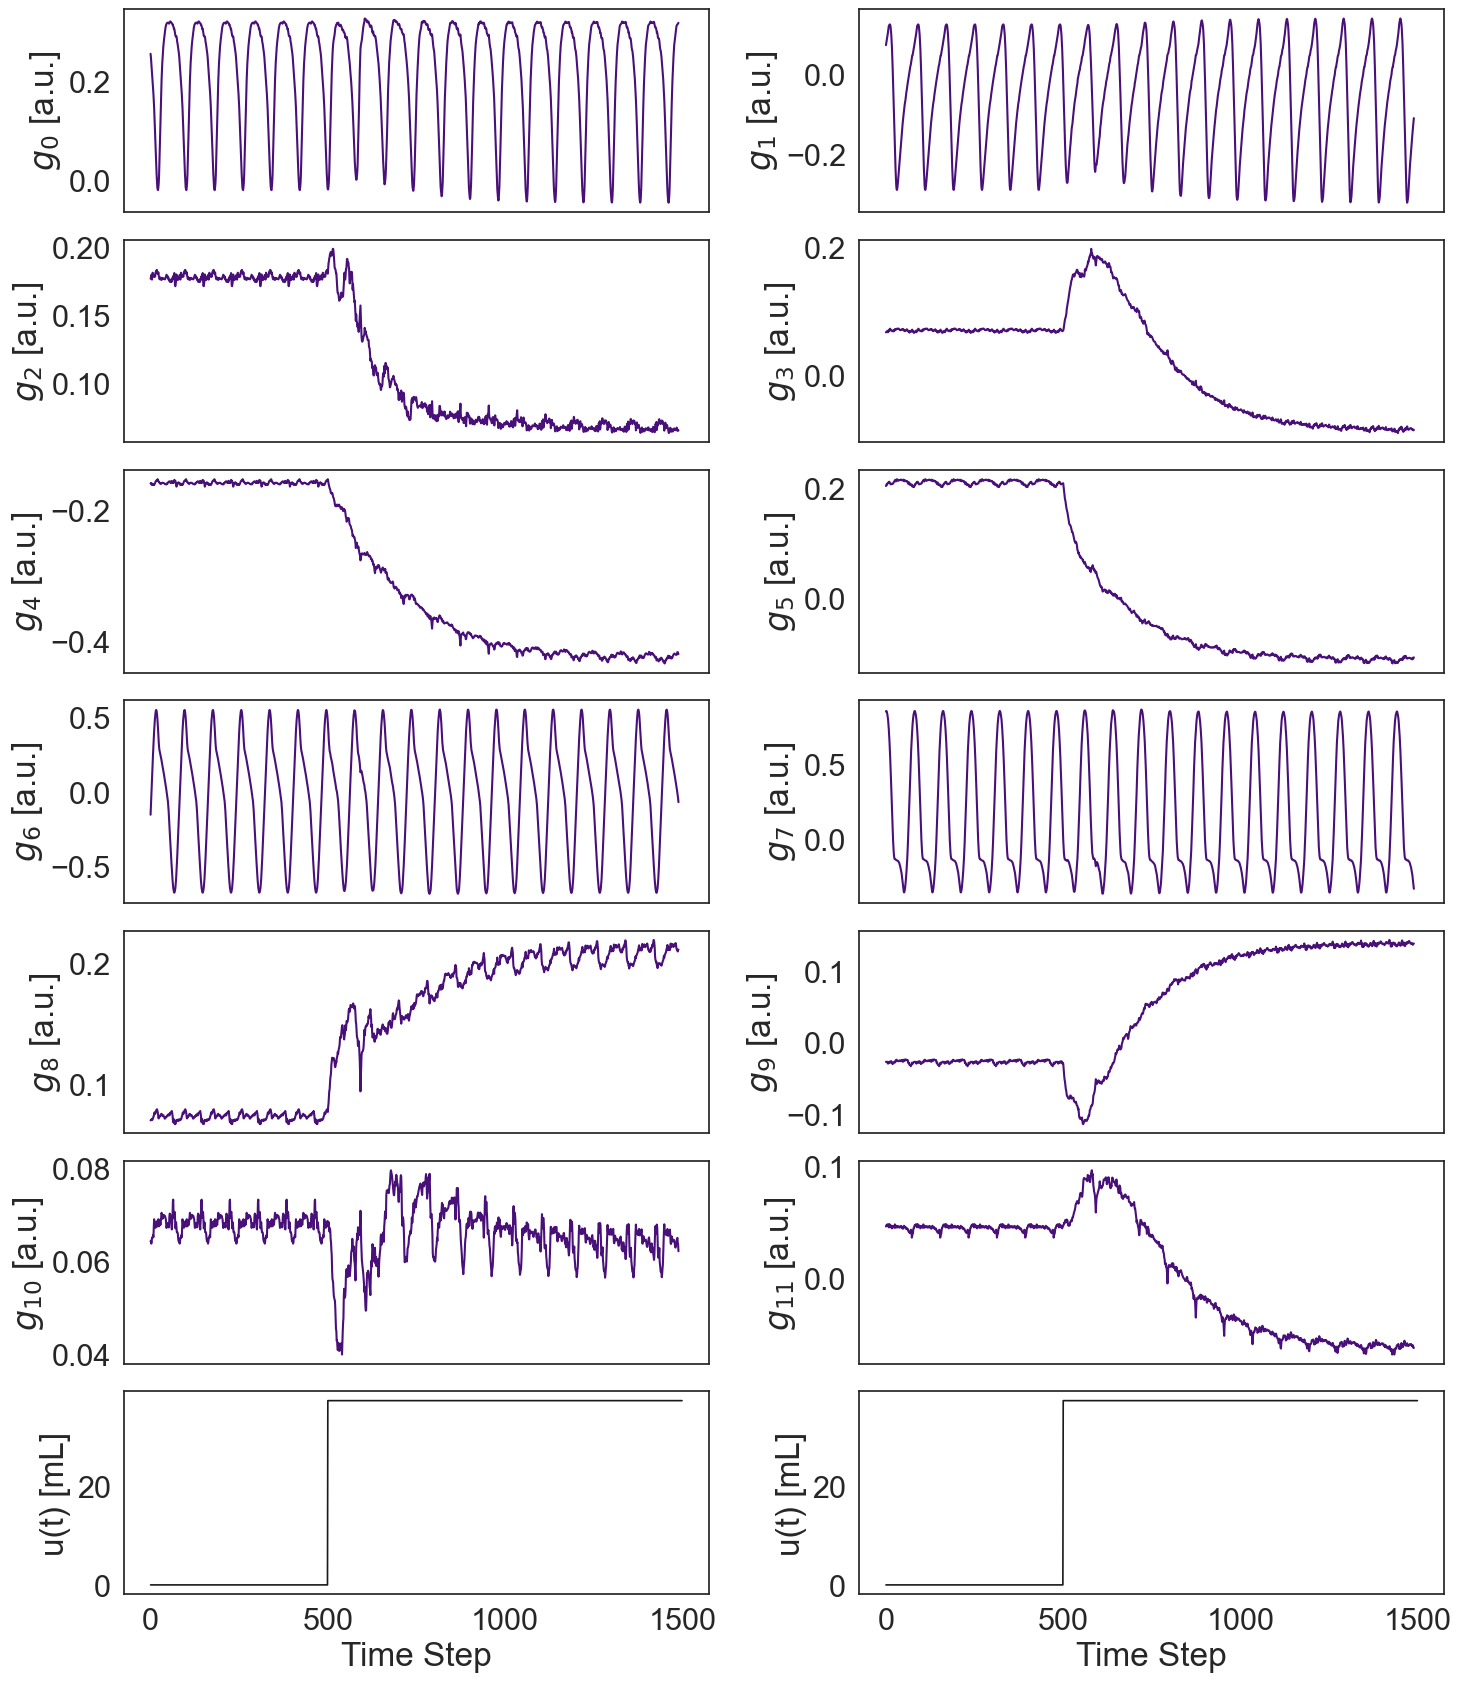

In [6]:
latent_dim = yk.shape[1]
yk_trimmed = yk[:params['len_time']-params['num_shifts']]

fig, axes = plt.subplots(7, 2, figsize=(15, fig_h), sharex=True)
axes = np.atleast_1d(axes).flatten()

for i in range(latent_dim):
    axes[i].plot(range(0,len(yk_trimmed)), yk_trimmed[:, i], linewidth=1.5, color="#481078")
    axes[i].set_ylabel(f'$g_{{{i}}}$ [a.u.]', fontsize=24)
    axes[i].tick_params(axis='both', labelsize=22)

nu.plot_control_panel(axes[-1], u_seq)
nu.plot_control_panel(axes[-2], u_seq)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(results_base_path / "figures" / "figure4b.svg", format='svg')
plt.show()

##### Figure 5a

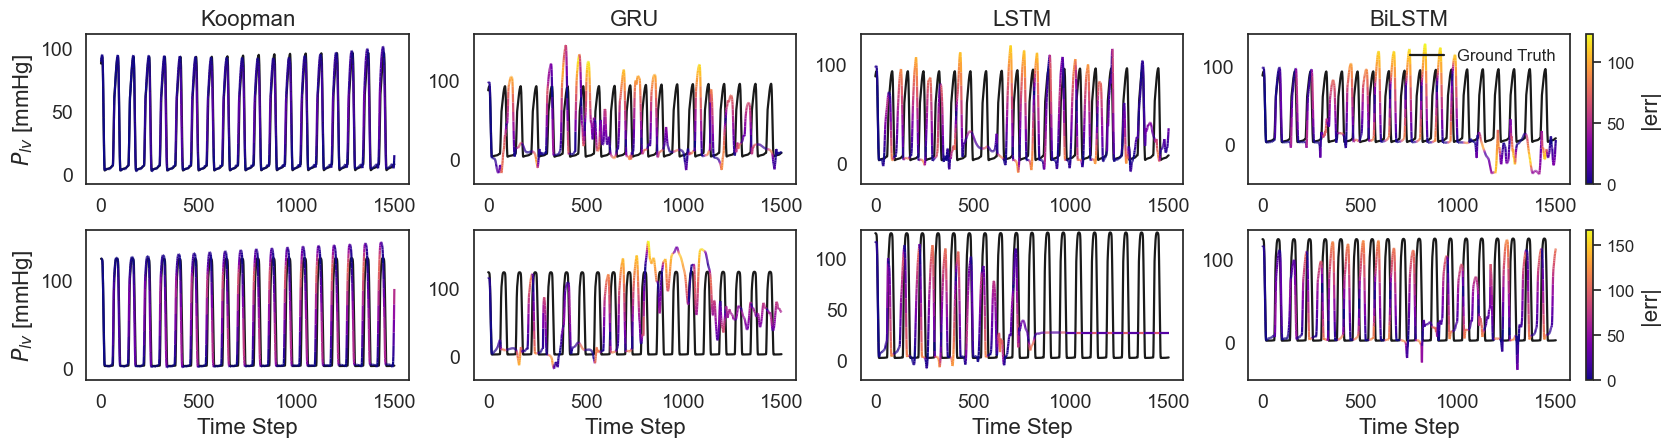

In [7]:
# Load postprocessing result files
paths = {
    'Koopman': results_base_path / "koopman" / "koopman_postprocessing_results.pkl",
    'GRU':     results_base_path / "gru"     / "gru_postprocessing_results.pkl",
    'LSTM':    results_base_path / "lstm"    / "lstm_postprocessing_results.pkl",
    'BiLSTM':  results_base_path / "bilstm"  / "bilstm_postprocessing_results.pkl",
}
results = {
    model_name: pickle.load(path.open('rb'))
    for model_name, path in paths.items()
}

models = list(results.keys())

true = results['Koopman']['true_per_trajectory']
pred = {m: results[m]['pred_per_trajectory'] for m in ['Koopman','GRU','LSTM','BiLSTM']}
rmse = results['Koopman']['rmse_per_trajectory']
ctrl = results['Koopman'].get('u_per_trajectory')
n, T, _ = true.shape
ctrl = ctrl.reshape(n, T) if ctrl is not None else None
idxs = np.argsort(rmse)[[0, -1]]
plv = 7

fig, axes = plt.subplots(2, 4, figsize=(18, 4.5))
axes = np.atleast_2d(axes)
plt.subplots_adjust(left=0.07, right=0.92, hspace=0.3, wspace=0.2)

for r, i in enumerate(idxs):
    y = true[i][:, plv]
    errs = [np.abs(pred[m][i][:, plv] - y) for m in models]
    vmax = np.max([e.max() for e in errs]) + 1e-12
    norm = nu.colors.Normalize(vmin=0, vmax=vmax)
    for c, m in enumerate(models):
        ax = axes[r, c]
        ax.plot(y, 'k', lw=1.6, label='Ground Truth')
        nu.coloured_pred(ax, y, pred[m][i][:, plv], plt.get_cmap('plasma'), norm)
        if r == 0: ax.set_title(m, fontsize=16)
        if c == 0: ax.set_ylabel(f'{ylab[plv]} [mmHg]', fontsize=16)
        if r == 1: ax.set_xlabel('Time Step', fontsize=16)
        ax.tick_params(labelsize=14)
        ax.grid(False)
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
    fig.colorbar(sm, ax=axes[r, :], orientation='vertical', fraction=0.02, pad=0.01
    ).ax.set_ylabel('|err|', fontsize=16)

axes[0, -1].legend(frameon=False, fontsize=12, loc='upper right')
plt.savefig(results_base_path / "figures/figure5a.svg", format='svg', bbox_inches='tight')
plt.show()

##### Figure 5b-e

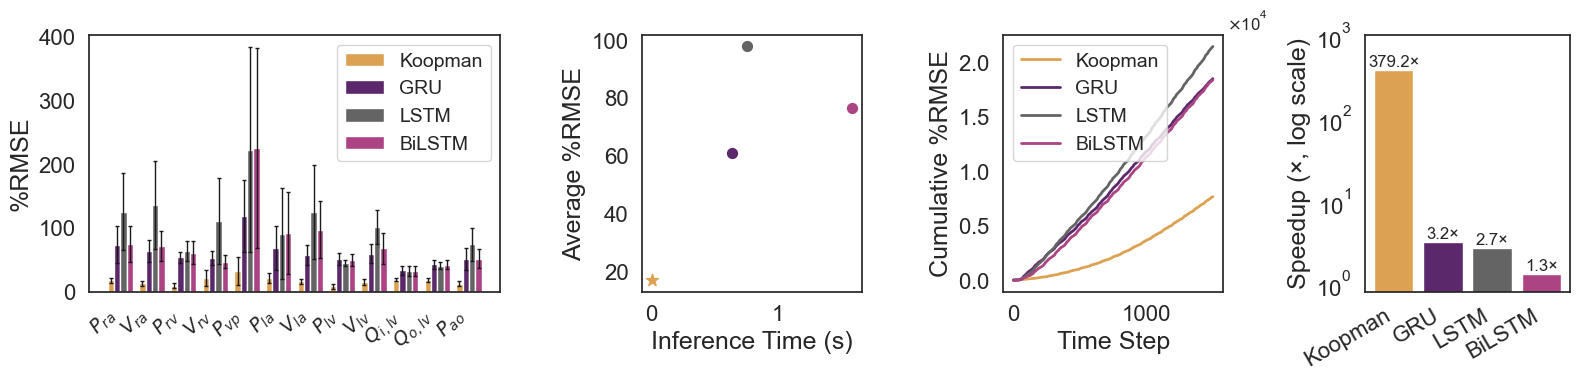

In [8]:
summary = {'R²': {}, '%RMSE (mean ± CI)': {}, 'Inference Time (s)': {},
           'Speedup': {}, 'Parameter Count': {}}

for model_name, res in results.items():
    pct_ps = res['pct_per_traj_ps']
    r2 = res['global_r2_flat']
    inference_time_s = res['inference_times_s']
    n_params = res['n_params']
    summary['Parameter Count'][model_name] = f"{n_params:,}"
    summary['%RMSE (mean ± CI)'][model_name] = f"{pct_ps.mean():.1f} ± {nu.ci95(pct_ps):.1f}%"
    summary['R²'][model_name] = f"{r2:.2f}"
    summary['Inference Time (s)'][model_name] = f"{inference_time_s.mean():.3f}"
    summary['Speedup'][model_name] = f"{inference_time_full_model_s/inference_time_s.mean():.1f}x"

df_traj = pd.DataFrame(summary).T
df_traj.index.name = 'Metric'

# Use custom palette
custom_palette = ["#dda251", "#5a286b", "#646464", "#ac4484"]

x = np.arange(len(ylab))
width = 0.8 / len(models)

# Per-signal %RMSE stats
means = np.vstack([results[m]['pct_per_signal'].mean(0) for m in models])
stds = np.vstack([results[m]['pct_per_signal'].std(0)  for m in models])

# Global metrics
inf_times = [np.mean(results[m]['inference_times_s']) for m in models]
pct_rmse_flat = [np.mean(results[m]['pct_per_signal']) for m in models]
speedup_vals = [float(summary['Speedup'][m].replace('x', '')) for m in models]

# Setup figure
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4, width_ratios=[7.5, 4, 4, 3.75], figure=fig)
plt.rcParams['axes.grid'] = False

# Plot 1: Grouped bar chart
ax0 = fig.add_subplot(gs[0])
for i, m in enumerate(models):
    ax0.bar(x + i * width, means[i], width, yerr=stds[i], capsize=3,
            label=m, color=custom_palette[i % len(custom_palette)],
            error_kw={'elinewidth': 1, 'capsize': 1.5})
ax0.set(xticks=x + width * (len(models) - 1) / 2,
        xticklabels=ylab)
ax0.set_ylabel('%RMSE', fontsize=18)
ax0.tick_params(labelsize=16)
ax0.set_xticklabels(ylab, ha='right', fontsize=14, rotation=45)
ax0.legend(fontsize=14)

# Plot 2: Inference time vs avg %RMSE
ax1 = fig.add_subplot(gs[1])
for i, (x_val, y_val) in enumerate(zip(inf_times, pct_rmse_flat)):
    marker = '*' if models[i] == 'Koopman' else 'o'
    ax1.scatter(x_val, y_val,
                s=80 if marker == '*' else 50,
                color=custom_palette[i % len(custom_palette)],
                marker=marker, label=models[i])
ax1.set_xlabel('Inference Time (s)', fontsize=18)
ax1.set_ylabel('Average %RMSE', fontsize=18)
ax1.tick_params(labelsize=16)

# Plot 3: Cumulative %RMSE over time
ax2 = fig.add_subplot(gs[2])
for i, (name, res) in enumerate(results.items()):
    cum = res.get('cumulative_pct_per_traj', None)
    if cum is None:
        continue
    ax2.plot(np.nanmean(cum, axis=0),
             label=name,
             color=custom_palette[i % len(custom_palette)],
             linewidth=2)
ax2.set_xlabel('Time Step', fontsize=18)
ax2.set_ylabel('Cumulative %RMSE', fontsize=18)
fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
ax2.yaxis.set_major_formatter(fmt)
ax2.yaxis.get_offset_text().set_x(1.02)
ax2.yaxis.get_offset_text().set_fontsize(12)
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=14)

# Plot 4: Speedup bar chart
ax3 = fig.add_subplot(gs[3])
bars = ax3.bar(models, speedup_vals,
               color=[custom_palette[i % len(custom_palette)] for i in range(len(models))])
ax3.set_yscale('log')
ax3.set_ylabel('Speedup (×, log scale)', fontsize=18)
ax3.set_ylim(0.8, 1000)
ax3.tick_params(labelsize=16)
ax3.set_xticks(np.arange(len(models)))
ax3.set_xticklabels(models, rotation=30, ha='right')
[ax3.text(i, val * 1.1, f"{val:.1f}×", ha='center', fontsize=12)
 for i, val in enumerate(speedup_vals)]

# Save and show
plt.tight_layout()
plt.savefig(results_base_path / "figures/figure5b-e.svg", format='svg')
plt.show()


##### Table 3

In [9]:
display(df_traj)
alpha = 0.05
model_names = list(results.keys())
data = [results[mdl]['pct_per_traj_flat'] for mdl in model_names]

print("\n=== Statistical Testing for %RMSE ===")

# 1) Test for normality
norm_ps = [shapiro(d).pvalue for d in data]
print("Normality p-values:", dict(zip(model_names, norm_ps)))
all_normal = all(p > alpha for p in norm_ps)

# 2) Global test
if all_normal:
    stat, pval = f_oneway(*data)
    print(f"ANOVA: F = {stat:.3f}, p = {pval:.3f}")
else:
    stat, pval = kruskal(*data)
    print(f"Kruskal–Wallis: H = {stat:.3f}, p = {pval:.3f}")

# 3) Pairwise comparisons with Bonferroni correction
significant_models = set()
ncomp = len(data) * (len(data) - 1) / 2

for i, j in combinations(range(len(data)), 2):
    if all_normal:
        stat, p = ttest_ind(data[i], data[j])
    else:
        stat, p = mannwhitneyu(data[i], data[j], alternative='two-sided')
    
    adj_p = min(p * ncomp, 1.0)
    print(f"{model_names[i]} vs {model_names[j]}: p = {p:.3f}, p_adj = {adj_p:.3f}")
    
    if adj_p < alpha:
        # Mark the better (lower RMSE) model
        better = model_names[i] if np.mean(data[i]) < np.mean(data[j]) else model_names[j]
        significant_models.add(better)


,Koopman,GRU,LSTM,BiLSTM
Metric,,,,
R²,0.71,-1.46,-6.50,-2.68
%RMSE (mean ± CI),17.1 ± 1.3%,60.9 ± 3.2%,97.8 ± 10.9%,76.4 ± 7.7%
Inference Time (s),0.005,0.640,0.758,1.582
Speedup,379.2x,3.2x,2.7x,1.3x
Parameter Count,"17,239,600","814,092","1,083,404","2,166,796"



=== Statistical Testing for %RMSE ===
Normality p-values: {'Koopman': np.float64(0.18750486113124631), 'GRU': np.float64(0.8403523970858399), 'LSTM': np.float64(0.5510791033138764), 'BiLSTM': np.float64(0.40160379207887004)}
ANOVA: F = 133.663, p = 0.000
Koopman vs GRU: p = 0.000, p_adj = 0.000
Koopman vs LSTM: p = 0.000, p_adj = 0.000
Koopman vs BiLSTM: p = 0.000, p_adj = 0.000
GRU vs LSTM: p = 0.019, p_adj = 0.112
GRU vs BiLSTM: p = 0.858, p_adj = 1.000
LSTM vs BiLSTM: p = 0.012, p_adj = 0.069


##### Table 4

In [10]:
cols = ['RMSE ± CI', '%RMSE ± CI', 'R² ± CI', 'Bias ± LoA']

for mdl in models:
    r = results[mdl]
    df = pd.DataFrame([
        (f"{a:.1f} ± {b:.1f}", f"{c:.1f}% ± {d:.1f}%", f"{e:.1f} ± {f:.1f}", f"{g:.1f} ± [{h:.1f}, {i:.1f}]")
        for a, b, c, d, e, f, g, h, i in zip(
            r['rmse_mean'], r['rmse_ci'], r['pct_mean'], r['pct_ci'],
            r['r2_mean'], r['r2_ci'], r['bias_mean'], r['loa_lower'], r['loa_upper']
        )
    ], index=[y.strip('$') for y in ylab], columns=cols)
    
    print(f"{mdl}:")
    display(df)
    print()

Koopman:


,RMSE ± CI,%RMSE ± CI,R² ± CI,Bias ± LoA
P_{ra},0.7 ± 0.0,18.1% ± 1.1%,0.3 ± 0.1,"0.1 ± [-1.3, 1.5]"
V_{ra},6.2 ± 0.6,13.1% ± 1.3%,0.8 ± 0.0,"-0.1 ± [-11.6, 11.4]"
P_{rv},2.9 ± 0.3,9.4% ± 1.2%,0.9 ± 0.0,"-0.1 ± [-5.5, 5.3]"
V_{rv},19.7 ± 2.8,21.0% ± 3.5%,0.2 ± 0.2,"8.3 ± [-21.4, 38.0]"
P_{vp},1.4 ± 0.2,32.8% ± 6.0%,-0.6 ± 0.8,"-0.2 ± [-2.3, 1.8]"
P_{la},1.8 ± 0.2,21.3% ± 2.1%,0.3 ± 0.1,"0.1 ± [-3.0, 3.2]"
V_{la},6.6 ± 0.8,16.5% ± 1.2%,0.5 ± 0.1,"-0.6 ± [-11.7, 10.6]"
P_{lv},10.3 ± 1.6,8.5% ± 1.2%,0.9 ± 0.0,"0.3 ± [-19.6, 20.1]"
V_{lv},12.9 ± 1.1,14.9% ± 1.4%,0.7 ± 0.0,"2.5 ± [-19.1, 24.0]"
"Q_{i,lv}",97.1 ± 6.8,18.6% ± 0.6%,0.3 ± 0.0,"5.6 ± [-183.0, 194.2]"



GRU:


,RMSE ± CI,%RMSE ± CI,R² ± CI,Bias ± LoA
P_{ra},2.8 ± 0.2,74.2% ± 8.0%,-12.2 ± 2.9,"1.0 ± [-3.8, 5.7]"
V_{ra},29.4 ± 1.4,64.2% ± 4.8%,-5.1 ± 1.1,"11.4 ± [-37.5, 60.4]"
P_{rv},16.8 ± 0.5,54.0% ± 2.5%,-1.1 ± 0.2,"-0.3 ± [-32.3, 31.6]"
V_{rv},49.4 ± 1.8,53.1% ± 3.2%,-2.8 ± 0.3,"-5.6 ± [-97.5, 86.4]"
P_{vp},5.0 ± 0.4,119.3% ± 15.7%,-18.9 ± 5.8,"-0.2 ± [-8.1, 7.7]"
P_{la},5.8 ± 0.4,68.7% ± 9.5%,-7.1 ± 2.3,"0.2 ± [-9.5, 9.8]"
V_{la},22.0 ± 1.3,57.7% ± 4.2%,-4.9 ± 0.8,"2.8 ± [-33.4, 39.0]"
P_{lv},60.6 ± 2.8,52.0% ± 2.6%,-1.0 ± 0.2,"-1.5 ± [-115.8, 112.9]"
V_{lv},51.2 ± 3.3,60.1% ± 4.0%,-3.1 ± 0.6,"2.3 ± [-85.1, 89.7]"
"Q_{i,lv}",177.0 ± 4.8,33.5% ± 1.8%,-1.1 ± 0.1,"-10.9 ± [-353.0, 331.2]"



LSTM:


,RMSE ± CI,%RMSE ± CI,R² ± CI,Bias ± LoA
P_{ra},5.1 ± 0.6,126.0% ± 17.1%,-38.8 ± 10.3,"1.8 ± [-5.4, 9.0]"
V_{ra},63.2 ± 8.7,136.5% ± 19.4%,-28.5 ± 6.9,"30.3 ± [-58.6, 119.2]"
P_{rv},19.9 ± 0.8,64.6% ± 4.4%,-2.0 ± 0.4,"5.3 ± [-28.2, 38.8]"
V_{rv},102.0 ± 15.6,111.5% ± 18.9%,-20.8 ± 5.6,"-63.3 ± [-205.0, 78.4]"
P_{vp},8.4 ± 1.0,223.2% ± 45.1%,-91.0 ± 38.5,"4.2 ± [-6.6, 14.9]"
P_{la},7.0 ± 0.6,91.4% ± 19.8%,-17.4 ± 8.2,"2.5 ± [-7.7, 12.6]"
V_{la},45.4 ± 5.8,125.3% ± 20.5%,-34.3 ± 10.2,"27.4 ± [-29.4, 84.2]"
P_{lv},53.2 ± 2.5,45.1% ± 1.3%,-0.5 ± 0.1,"-8.5 ± [-110.4, 93.3]"
V_{lv},85.5 ± 4.1,101.9% ± 7.4%,-10.8 ± 1.8,"23.4 ± [-106.8, 153.5]"
"Q_{i,lv}",171.7 ± 5.4,32.7% ± 2.1%,-1.0 ± 0.2,"-58.3 ± [-361.3, 244.8]"



BiLSTM:


,RMSE ± CI,%RMSE ± CI,R² ± CI,Bias ± LoA
P_{ra},3.0 ± 0.3,75.3% ± 7.8%,-12.3 ± 2.6,"-0.5 ± [-5.6, 4.6]"
V_{ra},33.5 ± 3.1,72.1% ± 6.4%,-6.4 ± 1.2,"-2.6 ± [-62.2, 57.0]"
P_{rv},19.1 ± 1.2,61.6% ± 5.0%,-1.9 ± 0.5,"-3.7 ± [-38.9, 31.6]"
V_{rv},44.2 ± 1.9,47.4% ± 3.0%,-2.0 ± 0.3,"-3.5 ± [-85.8, 78.8]"
P_{vp},8.8 ± 1.2,225.5% ± 44.0%,-90.8 ± 41.0,"3.7 ± [-8.8, 16.2]"
P_{la},7.4 ± 0.6,92.5% ± 17.9%,-16.2 ± 7.1,"1.4 ± [-10.6, 13.3]"
V_{la},36.0 ± 3.2,97.7% ± 12.3%,-18.3 ± 5.3,"13.2 ± [-42.9, 69.2]"
P_{lv},58.2 ± 3.1,49.9% ± 2.6%,-0.9 ± 0.2,"-8.1 ± [-119.5, 103.2]"
V_{lv},57.8 ± 5.7,68.1% ± 7.0%,-4.6 ± 1.2,"3.8 ± [-96.4, 104.0]"
"Q_{i,lv}",173.0 ± 5.9,32.8% ± 2.0%,-1.0 ± 0.2,"-16.2 ± [-351.2, 318.7]"


##### Figure S1

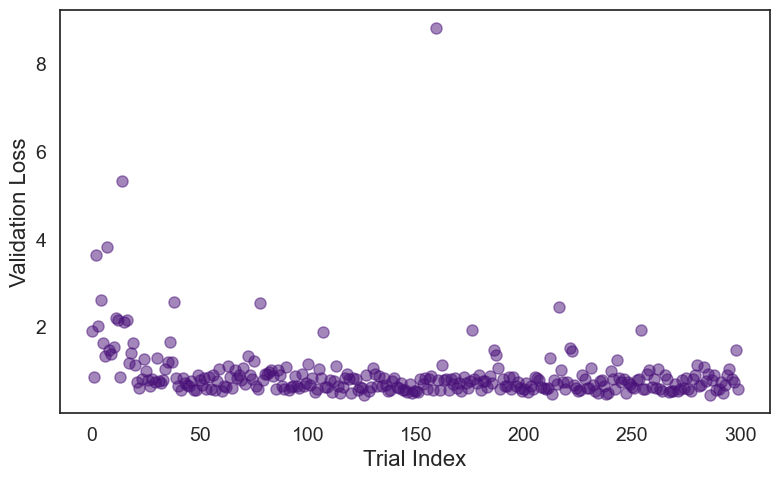

In [11]:
df = pd.read_csv(results_base_path / "optuna_runs" / "koopman_hyperparam_search_20250713_193701.csv")
#df_complete = df[df['State'] == 'COMPLETE'].copy()
df_complete = df.copy()  # Use all trials for plotting
df_complete.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.plot( df_complete.index, df_complete['Value'], linestyle='None', marker='o', label='Validation Loss', markersize=8, alpha=0.5, color="#481078")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Trial Index", fontsize=16)
plt.ylabel("Validation Loss", fontsize=16)
plt.tight_layout()
plt.savefig(results_base_path / "figures" / "supplementary_figure1.svg", format='svg')
plt.show()

##### Figure S2

C:\Users\MaxHaberbusch\AppData\Local\Temp\ipykernel_8504\499339585.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Sensitivity (std of grouped mean)', y='Hyperparameter', palette='plasma_r')


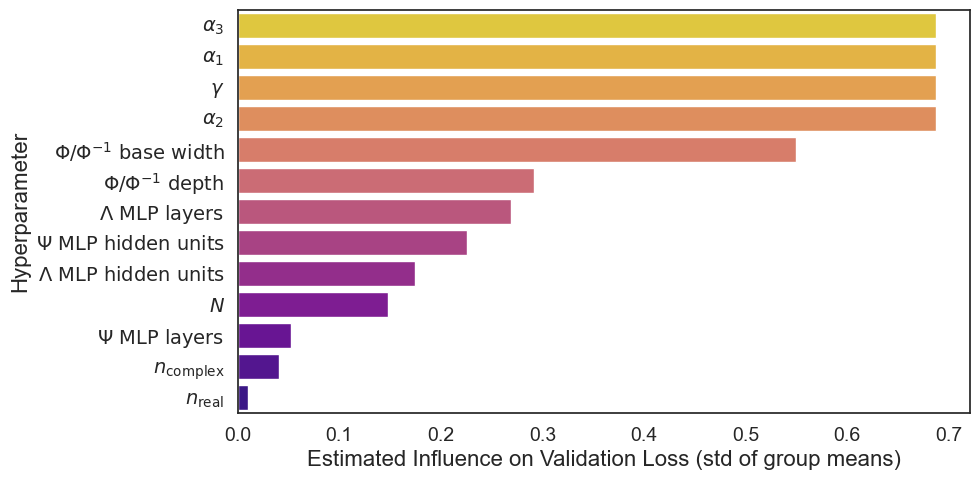

In [12]:
param_cols = [col for col in df_complete.columns if col.startswith("Param ")]
param_importance = {}
for col in param_cols:
    groups = df_complete.groupby(col)['Value']
    group_means = groups.mean()
    importance = group_means.std()  # you can use variance or range (np.ptp) if preferred
    param_importance[col] = importance

importance_df = pd.DataFrame({
    'Hyperparameter': list(param_importance.keys()),
    'Sensitivity (std of grouped mean)': list(param_importance.values())
}).sort_values(by='Sensitivity (std of grouped mean)', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importance_df, x='Sensitivity (std of grouped mean)', y='Hyperparameter', palette='plasma_r')
plt.xlabel('Estimated Influence on Validation Loss (std of group means)', fontsize=16)
plt.ylabel('Hyperparameter', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Set custom labels for the parameters so they are consistent with the paper
param_labels = [
    r'$\alpha_3$',
    r'$\alpha_1$',
    r'$\gamma$',
    r'$\alpha_2$',
    r'$\Phi/\Phi^{-1}\ \text{base width}$',
    r'$\Phi/\Phi^{-1}\ \text{depth}$',
    r'$\Lambda\ \text{MLP layers}$',
    r'$\Psi\ \text{MLP hidden units}$',
    r'$\Lambda\ \text{MLP hidden units}$',
    r'$N$',
    r'$\Psi\ \text{MLP layers}$',
    r'$n_{\text{complex}}$',
    r'$n_{\text{real}}$',
]

# set custom labels
plt.yticks(ticks=range(len(param_labels)), labels=param_labels, fontsize=14)
plt.tight_layout()
plt.savefig(results_base_path / "figures" / "supplementary_figure2.svg")
plt.show()


##### Figure S3

In [13]:
top5_params = importance_df['Hyperparameter'].head(5).tolist()
selected_dims = top5_params + ['Value']
df_plot = df_complete[selected_dims].copy()

fig = px.parallel_coordinates(
    df_plot,
    dimensions=selected_dims,
    color='Value',
    color_continuous_scale='plasma',
    range_color=[df_complete['Value'].min(), df_complete['Value'].max()],
    width=1800,
    height=600,
    # Set custom labels for the parameters so they are consistent with the paper
    labels = {
        'Param enc_start': 'Φ / Φ⁻¹ based width',
        'Param L2_lam': 'α₃',
        'Param recon_lam': 'α₁',
        'Param Linf_lam': 'α₂',
        'Param control_gain': 'γ',
        'Value': 'Loss'
    },
)
fig.update_layout(
    font=dict(
        size=22,       # Base font size for labels, tick labels, and legend
        family="Arial",  # You can choose another font
    )
)

fig.write_image(results_base_path / "figures" / "supplementary_figure3.svg")
fig.show()